In [27]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf
from sklearn.metrics import mean_squared_error

from tensorflow import keras
# plt.rcParams['font.sans-serif']=['SimHei']
# plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr
print(tf.__version__)
print(sys.version_info)
import h2o
from h2o.automl import H2OAutoML
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)
from tensorflow.keras.layers import Dense, Dropout, LayerNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber
from tensorflow.keras.callbacks import EarlyStopping

2.10.1
sys.version_info(major=3, minor=10, micro=5, releaselevel='final', serial=0)
matplotlib 3.5.2
numpy 1.23.1
pandas 1.4.3
sklearn 1.2.1
tensorflow 2.10.1
tensorflow.keras 2.10.0


In [15]:
if os.environ.get('COMPUTERNAME') == 'DESKTOP-EQAO3M5' or os.environ.get('NAME') == 'DESKTOP-EQAO3M5':
  if os.environ.get('WSL_DISTRO_NAME') == 'Ubuntu-20.04':
    computer_flag = 'home_WSL2'
  else:
    computer_flag = 'home'
else:
  computer_flag = 'office'

if computer_flag == 'home':
  root_dir = "F:/github/pythonScript/seafog/"
elif computer_flag == 'home_WSL2':
  root_dir = "/mnt/f/github/pythonScript/seafog/"
else:
  root_dir = "H:/github/python/seafog/"

def linear_vis(x):
    if(x <= 1000.0):
      y = x/1000.0
    elif(x > 1000.0 and x <= 10000.0):
      y = (x-1000.0)/9000.0 + 1.0
    elif( x > 10000.0  and x <= 30000.0):
      y = (x-10000.0)/20000 + 2.0
    else:
      y = 3.0
    return y

def reverse_linear_vis(x):
    if(x<0):
      y = 1
    elif(x <= 1.0):
      y = x*1000.0
    elif(x <= 2.0):
      y = (x - 1.0)*9000.0 + 1000.0
    elif(x <= 3.0):
      y = (x-2.0)*20000 + 10000.0
    else:
      y = 30000.0
    return y

def setDataset(df, x_columns):
    df['t_td'] =  df['t2mm'] - df['t2md']
    df['td_sst'] =  df['t2md'] - df['sstk']
    df['t_sst'] =  df['t2mm'] - df['sstk']
    df['delta_theta'] = df['theta925'] - df['theta1000']
    df['delta_theta_e'] = df['theta_e925'] - df['theta_e1000']
    df_x = df.loc[:, x_columns]
    df_y = df['station_vis_linear']
    _x = df_x.to_numpy()
    _y = df_y.to_numpy()
    return (_x, _y)


def getLevelRatio(df):
    length = len(df)
    ratio_fog = len(df.loc[df['prediction']<=1.0])/length
    ratio_mist = len(df.loc[(df['prediction']>1.0) & (df['prediction']<=2.0)])/length
    ratio_clear = len(df.loc[df['prediction']>2.0])/length
    print(f'比例: 雾:{ratio_fog}, 轻雾{ratio_mist}, 无雾{ratio_clear}')
    return (ratio_fog, ratio_mist, ratio_clear)

def get_fog_TSscore(df, threshold=1.0):
    length = len(df)
    NA = len(df.loc[(df['prediction']<=threshold) & (df['y']<=threshold)]) # 正确数
    NB = len(df.loc[(df['prediction']<=threshold) & (df['y']>threshold)]) # 空报数
    NC = len(df.loc[(df['prediction']>threshold) & (df['y']<=threshold)]) # 空报数
    TS_score = NA/(NA + NB + NC)
    return TS_score

def get_NWP_score(df):
    y = df['station_vis'].apply(linear_vis)
    y_p = df['visi'].apply(linear_vis)
    df_s = pd.DataFrame({'prediction':y_p, 'y':y})
    df_s.dropna(inplace=True)
    df_s_fog = df_s.loc[df_s['y']<=1.0]
    df_s_mist = df_s.loc[(df_s['y']>1.0) & (df_s['y']<=2.0)]
    df_s_clear = df_s.loc[df_s['y']>2.0]
    print('* 实况为雾时:', end=' ')
    getLevelRatio(df_s_fog)
    # print('-------------')
    print('* 实况为轻雾时:', end=' ')
    # print('-------------')
    getLevelRatio(df_s_mist)
    print('* 实况为无雾时:', end=' ')
    getLevelRatio(df_s_clear)
    print('* TS评分:', end=' ')
    TS_fog = get_fog_TSscore(df_s, threshold=1.0)
    TS_fog_mist = get_fog_TSscore(df_s, threshold=2.0)
    print(f'雾: {TS_fog}, 轻雾及雾: {TS_fog_mist}')

def getScore(x,y, model,type='tf'):
    if type == 'tf':
      predictions = model(x).numpy()
      y_p = predictions[:,0]
    elif type == 'h2o': 
      predictions = model.predict(x)
      y_p = predictions.as_data_frame().values.flatten()
    elif type == 'transformer':
      predictions = model.predict(x)
      y_p = predictions.flatten()
    df_s = pd.DataFrame({'prediction':y_p, 'y':y})
    df_s_fog = df_s.loc[df_s['y']<=1.0]
    df_s_mist = df_s.loc[(df_s['y']>1.0) & (df_s['y']<=2.0)]
    df_s_clear = df_s.loc[df_s['y']>2.0]
    print('* 实况为雾时:', end=' ')
    getLevelRatio(df_s_fog)
    # print('-------------')
    print('* 实况为轻雾时:', end=' ')
    # print('-------------')
    getLevelRatio(df_s_mist)
    print('* 实况为无雾时:', end=' ')
    getLevelRatio(df_s_clear)
    print('* TS评分:', end=' ')
    TS_fog = get_fog_TSscore(df_s, threshold=1.0)
    TS_fog_mist = get_fog_TSscore(df_s, threshold=2.0)
    print(f'雾: {TS_fog}, 轻雾及雾: {TS_fog_mist}')
    return {'TS_fog':TS_fog,'TS_mist':TS_fog_mist}

In [3]:
fog_dataset_hdf = os.path.normpath(os.path.join(root_dir, './data/collection/fog_dataset_hdf66_fc120h_v2.h5'))
store_dataset = pd.HDFStore(fog_dataset_hdf, mode='r')
print(store_dataset.keys())
df_train = store_dataset.get('train')
df_valid =store_dataset.get('valid')
df_test = store_dataset.get('test')
df_valid_test = store_dataset.get('valid_test')

real_fcHour_list = list(range(0, 72+1, 3)) + list(range(78, 168+1, 6))
df_test_real = df_test.loc[df_test['fc_hour'].isin(real_fcHour_list) ].copy(deep=True)
df_valid_test_real = df_valid_test.loc[df_valid_test['fc_hour'].isin(real_fcHour_list) ].copy(deep=True)

x_columns = ['t_td', 'td_sst','t_sst','v100', 'v10m', 'u100', 'u10m', 't2mm', 't2md', 'sstk','year_sin','year_cos', 'day_sin', 'day_cos','delta_theta','delta_theta_e','theta_e925']

(train_x, train_y) = setDataset(df_train, x_columns)
(valid_x, valid_y) = setDataset(df_valid, x_columns)
(test_x,  test_y)  = setDataset(df_test, x_columns)
(valid_test_x, valid_test_y) = setDataset(df_valid_test, x_columns)

(test_real_x,  test_real_y)  = setDataset(df_test_real, x_columns)
(valid_test_real_x, valid_test_real_y) = setDataset(df_valid_test_real, x_columns)



print(train_x.shape)
print(train_y.shape)

scaler = StandardScaler()
train_x_scaled = scaler.fit_transform(train_x)
test_x_scaled  = scaler.transform(test_x)
valid_x_scaled = scaler.transform(valid_x)
valid_test_x_scaled = scaler.transform(valid_test_x)

test_x_real_scaled  = scaler.transform(test_real_x)
valid_test_x_real_scaled = scaler.transform(valid_test_real_x)


keep_cols = ['t_td', 'td_sst','t_sst','year_sin','year_cos', 'day_sin', 'day_cos','delta_theta','delta_theta_e'] # 不需要标准化变量的参数

for iColumn in keep_cols:
    index = x_columns.index(iColumn)
    train_x_scaled[:,index] = train_x[:,index]
    valid_x_scaled[:,index] = valid_x[:,index]
    test_x_scaled[:,index]  = test_x[:,index]
    valid_test_x_scaled[:,index]  = valid_test_x[:,index]

    test_x_real_scaled[:,index]  = test_real_x[:,index]
    valid_test_x_real_scaled[:,index]  = valid_test_real_x[:,index]


['/test', '/train', '/valid', '/valid_test']
(469269, 17)
(469269,)


In [26]:

# Transformer block
class TransformerBlock(Model):
    def __init__(self, embed_dim):
        super(TransformerBlock, self).__init__()
        self.att = tf.keras.layers.MultiHeadAttention(num_heads=2, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential(
            [Dense(32, activation="relu"), Dense(embed_dim),]
        )
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        return self.layernorm2(out1 + ffn_output)

# Regression model
class RegressionModel(Model):
    def __init__(self, embed_dim):
        super(RegressionModel, self).__init__()
        self.reshape = tf.keras.layers.Reshape((-1, embed_dim))
        self.transformer_block = TransformerBlock(embed_dim)
        self.dropout = Dropout(0.1)
        self.dense = Dense(1)
        self.dense8 = Dense(8)

    def call(self, inputs, training):
        x = self.reshape(inputs)
        x = self.transformer_block(x)
        x = self.dropout(x, training=training)
        x = self.dense8(x)
        return self.dense(x)


Epoch 1/10
14665/14665 [==============================] - 140s 9ms/step - loss: 0.3520 - val_loss: 0.3902
Epoch 2/10
14665/14665 [==============================] - 135s 9ms/step - loss: 0.3487 - val_loss: 0.3985
Epoch 3/10
14665/14665 [==============================] - 140s 10ms/step - loss: 0.3487 - val_loss: 0.4050
Epoch 4/10
14665/14665 [==============================] - 137s 9ms/step - loss: 0.3487 - val_loss: 0.4118
Epoch 5/10
14665/14665 [==============================] - 139s 9ms/step - loss: 0.3487 - val_loss: 0.4111
Epoch 6/10
14665/14665 [==============================] - 136s 9ms/step - loss: 0.3487 - val_loss: 0.3895
Epoch 7/10
14665/14665 [==============================] - 139s 9ms/step - loss: 0.3487 - val_loss: 0.3957
Epoch 8/10
14665/14665 [==============================] - 135s 9ms/step - loss: 0.3487 - val_loss: 0.4032
Epoch 9/10
14665/14665 [==============================] - 139s 9ms/step - loss: 0.3487 - val_loss: 0.3965
Epoch 10/10
14665/14665 [====================

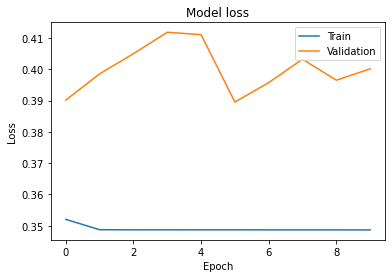

4190/4190 [==============================] - 21s 5ms/step


In [28]:


# Parameters
embed_dim = 17
epochs = 10
# 设置早停回调函数
early_stopping = EarlyStopping(monitor='val_loss', patience=3, mode='min')
# Build and compile the model
model = RegressionModel(embed_dim)
# model.compile(loss='mean_squared_error', optimizer=Adam())
model.compile(loss=Huber(), optimizer=Adam())

# Train the model
history = model.fit(train_x_scaled, train_y, epochs=epochs, 
                    validation_data=(valid_x_scaled, valid_y), callbacks=[early_stopping],)

# Visualize the training process
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Predict the test set
predictions = model.predict(test_x_scaled)


In [14]:
predictions.flatten()

array([1.4778734, 1.4762658, 1.4773098, ..., 1.5117869, 1.5150723,
       1.4982623], dtype=float32)

In [30]:
predictions = model(test_x_scaled).numpy()
y_p = predictions.flatten()
df_s = pd.DataFrame({'prediction':y_p, 'y':test_y})
print(df_s.head(10))

   prediction      y
0    1.504571  0.609
1    1.502565  0.609
2    1.503868  0.609
3    1.505741  0.609
4    1.505980  0.609
5    1.511173  0.609
6    1.513326  0.609
7    1.512344  0.609
8    1.512963  0.609
9    1.514060  0.609


In [16]:
print('#### ===================测试集==========')
getScore(test_x_scaled, test_y, model,'transformer')
print('#### ==============测试集+验证集==========')
getScore(valid_test_x_scaled, valid_test_y, model,'transformer')
print('#### ==================训练集==========')
getScore(train_x_scaled, train_y, model,'transformer')
print('#### ===============验证集==========')
getScore(valid_x_scaled, valid_y, model,'transformer')

#### ===================测试集==========
4190/4190 [==============================] - 15s 4ms/step
* 实况为雾时: 比例: 雾:0.0, 轻雾1.0, 无雾0.0
* 实况为轻雾时: 比例: 雾:0.0, 轻雾1.0, 无雾0.0
* 实况为无雾时: 比例: 雾:0.0, 轻雾1.0, 无雾0.0
* TS评分: 雾: 0.0, 轻雾及雾: 0.6666666666666666
#### ==============测试集+验证集==========
8380/8380 [==============================] - 30s 4ms/step


KeyboardInterrupt: 

模式评估损失函数0.3152541518211365


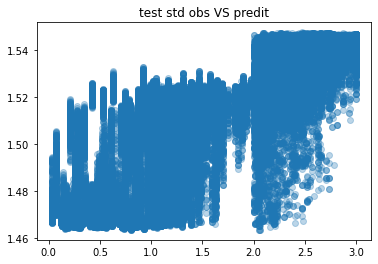

相关系数0.8166609842113892, p值为0.00000


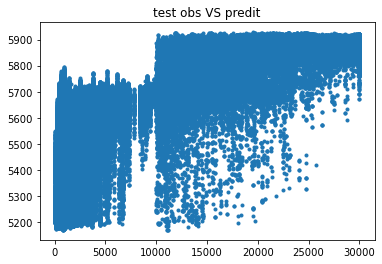

模式评估损失函数0.35769641399383545


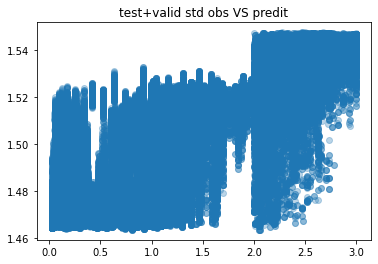

相关系数0.8208895409363043, p值为0.00000


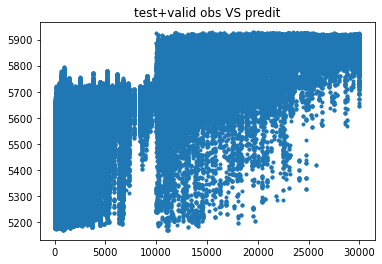

模式评估损失函数0.3485323488712311


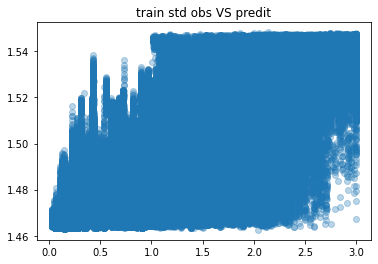

相关系数0.8515245500106308, p值为0.00000


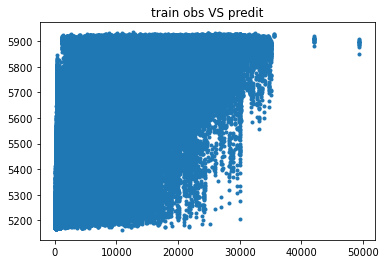

模式评估损失函数0.4001389443874359


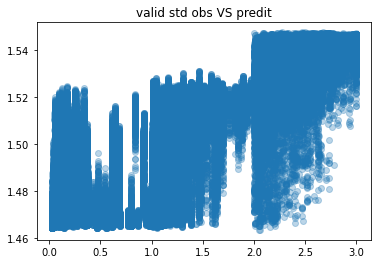

相关系数0.827509471037152, p值为0.00000


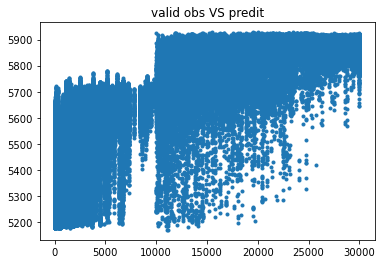

In [29]:
def showPredictions(x, y, origin_vis, titlePrefix=''):
    print(f'模式评估损失函数{model.evaluate(x, y, verbose=0)}')
    predictions = model(x).numpy()
    plt.scatter(y, predictions.flatten(), marker='o',  alpha=0.3)
    plt.title(f'{titlePrefix} std obs VS predit')
    plt.show()
    r,p = pearsonr(predictions.flatten(),y)
    print(f'相关系数{r}, p值为{p:.5f}')

    plt.plot(origin_vis, np.vectorize(reverse_linear_vis)(predictions[:,0]) ,'.')
    plt.title(f'{titlePrefix} obs VS predit')
    plt.show()
  
showPredictions(test_x_scaled, test_y, df_test['station_vis'].values, 'test')
showPredictions(valid_test_x_scaled, valid_test_y, df_valid_test['station_vis'].values, 'test+valid')
showPredictions(train_x_scaled, train_y, df_train['station_vis'].values, 'train')
showPredictions(valid_x_scaled, valid_y, df_valid['station_vis'].values, 'valid')